# Определение перспективного тарифа для телеком-компании.


## Описание проекта.

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов.
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

## Изучение данных из файла.

In [1]:
# импорт библиотек
# получение первых 5 строк таблиц
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

for data in [calls, internet, messages, tariffs, users]: 
    print(data.head(), end='\n--------------\n')

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
--------------
       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
--------------
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
--------------
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name

In [2]:
# получение общей информации о данных в таблицах
for data in [calls, internet, messages, tariffs, users]: 
    print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-N

Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [3]:
# описательная статистика
for data in [calls, internet, tariffs, users]: 
    print(data.describe(), end='\n--------------\n')

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000
--------------
             mb_used        user_id
count  149396.000000  149396.000000
mean      370.192426    1252.099842
std       278.300951     144.050823
min         0.000000    1000.000000
25%       138.187500    1130.000000
50%       348.015000    1251.000000
75%       559.552500    1380.000000
max      1724.830000    1499.000000
--------------
       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.00000

### Вывод.

На первый вгляд в данных есть некоторые неточности:
1. Нулевые значения в `duration` и `mb_used`.
2. Тип данных в `call_date`, `session_date`, `message_date`, `reg_date`, `churn_date` должен быть datetime.
    
Количество значений в столбце **users** различается, в данных есть пропущенные значения. Данные пропущены в дате прекращения пользования тарифом, значит тариф ещё действовал на момент выгрузки данных. Не будем их трогать.

## Подготовим данные.

Приведем данные к нужным типам.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

Нулевые значения в `duration` — длительность звонка в минутах, заменять не будем, это пропущенные звонки. Нулевые значения в `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах) оставим без изменений.

«Мегалайн» округляет секунды до минут, а мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону, поэтому округлим минуты в большую сторону для каждого звонка, а интеренет трафик округлим по месяцам.

In [5]:
# округление значений в большую сторону
calls['duration'] = np.ceil(calls['duration'])
# добавим столбец с месяцами
internet['month'] = internet['session_date'].dt.month
# сгруппируем обьем потраченного трафика по месяцам для каждого клиента
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
# переименуем столбец
internet_grouped.columns = ['mb_used']
# округлим значения в большую сторону
internet_grouped['mb_used'] = np.ceil(internet_grouped['mb_used'])
display(internet_grouped)

mb_used
user_id month         
1000    5       2254.0
        6      23234.0
        7      14004.0
        8      14056.0
        9      14569.0
...                ...
1498    10     20580.0
1499    9       1846.0
        10     17789.0
        11     17964.0
        12     13056.0

[3203 rows x 1 columns]

Посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [6]:
# добавим месяц
calls['month'] = calls['call_date'].dt.month
# количество сделанных звонков и израсходованных минут разговора по месяцам
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_grouped.columns = ['calls', 'duration']
display(calls_grouped)

calls  duration
user_id month                 
1000    5         22     159.0
        6         43     172.0
        7         47     340.0
        8         52     408.0
        9         58     466.0
...              ...       ...
1498    10        41     247.0
1499    9          9      70.0
        10        68     449.0
        11        74     612.0
        12        69     492.0

[3174 rows x 2 columns]

In [7]:
# добавим месяц
messages['month'] = messages['message_date'].dt.month
# количество отправленных сообщений по месяцам
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_grouped.columns = ['messages']
display(messages_grouped)

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

Объем израсходованного интернет-трафика по месяцам мы уже имеем, напомним его.

In [8]:
display(internet_grouped)

mb_used
user_id month         
1000    5       2254.0
        6      23234.0
        7      14004.0
        8      14056.0
        9      14569.0
...                ...
1498    10     20580.0
1499    9       1846.0
        10     17789.0
        11     17964.0
        12     13056.0

[3203 rows x 1 columns]

Посчитаем помесячную выручку с каждого пользователя.

In [9]:
# объединим сводные таблицы
data_grouped = calls_grouped.merge(messages_grouped, on=['user_id', 'month'], how='outer')
data_grouped = data_grouped.merge(internet_grouped, on=['user_id', 'month'], how='outer')
# добавим тариф для каждого пользователя
for user in data_grouped.index:
    data_grouped.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

display(data_grouped)

calls  duration  messages  mb_used tariff
user_id month                                           
1000    5       22.0     159.0      22.0   2254.0  ultra
        6       43.0     172.0      60.0  23234.0  ultra
        7       47.0     340.0      75.0  14004.0  ultra
        8       52.0     408.0      81.0  14056.0  ultra
        9       58.0     466.0      57.0  14569.0  ultra
...              ...       ...       ...      ...    ...
1489    9        NaN       NaN      32.0  17207.0  smart
        10       NaN       NaN      21.0  19560.0  smart
        11       NaN       NaN      20.0  17492.0  smart
        12       NaN       NaN      35.0  17323.0  smart
1476    4        NaN       NaN       NaN    531.0  ultra

[3214 rows x 5 columns]

Видим, что появились пустые значения. Они могли появиться, если пользователь использовал не все виды связи. Заменим пустые значения на 0.

In [10]:
print('Количество пропусков до замены: \n', data_grouped.isna().sum(), sep='')
# для каждого столбца заменим пустые значения на 0
for column in data_grouped.columns.values.tolist():
    data_grouped.loc[data_grouped[column].isna(), column] = 0
print('Количество пропусков после замены:\n', data_grouped.isna().sum(), sep='')

Количество пропусков до замены: 
calls        40
duration     40
messages    497
mb_used      11
tariff        0
dtype: int64
Количество пропусков после замены:
calls       0
duration    0
messages    0
mb_used     0
tariff      0
dtype: int64


In [24]:
# Код ревьювера
data_grouped.reset_index() \
    .merge(users[['user_id','tariff']],
           how='left', on = 'user_id',
           suffixes = ['_твой_способ','_c_помощью_merge'])

,user_id,month,calls,duration,messages,mb_used,tariff_твой_способ,revenue,city,region,tariff_c_помощью_merge
0,1000,5,22.0,159.0,22.0,2254.0,ultra,1950.00,Краснодар,Другие регионы,ultra
1,1000,6,43.0,172.0,60.0,23234.0,ultra,1950.00,Краснодар,Другие регионы,ultra
2,1000,7,47.0,340.0,75.0,14004.0,ultra,1950.00,Краснодар,Другие регионы,ultra
3,1000,8,52.0,408.0,81.0,14056.0,ultra,1950.00,Краснодар,Другие регионы,ultra
4,1000,9,58.0,466.0,57.0,14569.0,ultra,1950.00,Краснодар,Другие регионы,ultra
...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17207.0,smart,910.74,Санкт-Петербург,Другие регионы,smart
3210,1489,10,0.0,0.0,21.0,19560.0,smart,1370.31,Санкт-Петербург,Другие регионы,smart
3211,1489,11,0.0,0.0,20.0,17492.0,smart,966.41,Санкт-Петербург,Другие регионы,smart
3212,1489,12,0.0,0.0,35.0,17323.0,smart,933.40,Санкт-Петербург,Другие регионы,smart


Теперь займемся вычислениями.

In [11]:
# функция подсчета выручки по месяцам, для каждого пользователя
def revenue(row):
    calls = row['calls']
    duration = row['duration']
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
# вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика
# остаток умножить на значение из тарифного плана
# прибавить абонентскую плату, соответствующую тарифному плану
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_messages < 0:
            extra_messages = 0
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + tariffs.loc[0, 'rub_monthly_fee']
               )
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_messages < 0:
            extra_messages = 0
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                tariffs.loc[1, 'rub_per_minute'] * extra_duration + tariffs.loc[1, 'rub_monthly_fee']
                  )
    
data_grouped['revenue'] = data_grouped.apply(revenue, axis=1).round(2)
data_grouped.head()

calls  duration  messages  mb_used tariff  revenue
user_id month                                                    
1000    5       22.0     159.0      22.0   2254.0  ultra   1950.0
        6       43.0     172.0      60.0  23234.0  ultra   1950.0
        7       47.0     340.0      75.0  14004.0  ultra   1950.0
        8       52.0     408.0      81.0  14056.0  ultra   1950.0
        9       58.0     466.0      57.0  14569.0  ultra   1950.0

Теперь данные готовы для анализа и проверки гипотез.

## Проанализируем данные.

Опишим поведение клиентов оператора, исходя из выборки. 
* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
* Посчитаем среднее количество, дисперсию и стандартное отклонение. 
* Построем гистограммы и опишим распределения.

### Тариф «Смарт» и «Ультра».

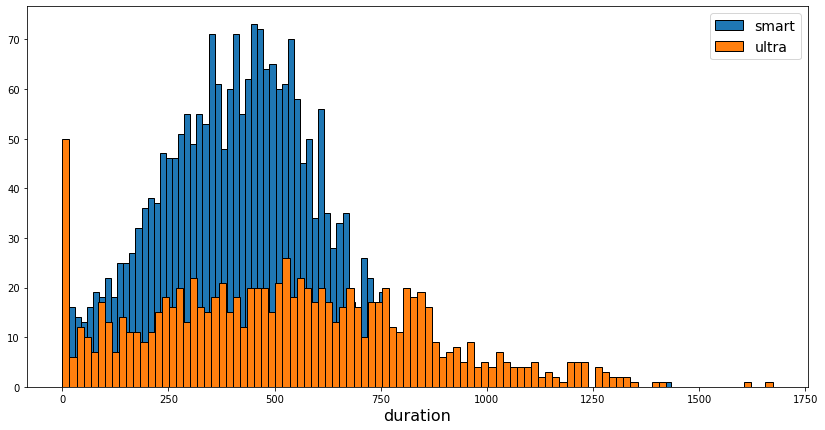

        Среднее  Дисперсия  Стандартное отклонение
tariff                                            
smart     417.9    36219.3                   190.3

        Среднее  Дисперсия  Стандартное отклонение
tariff                                            
ultra     526.6   100873.6                   317.6


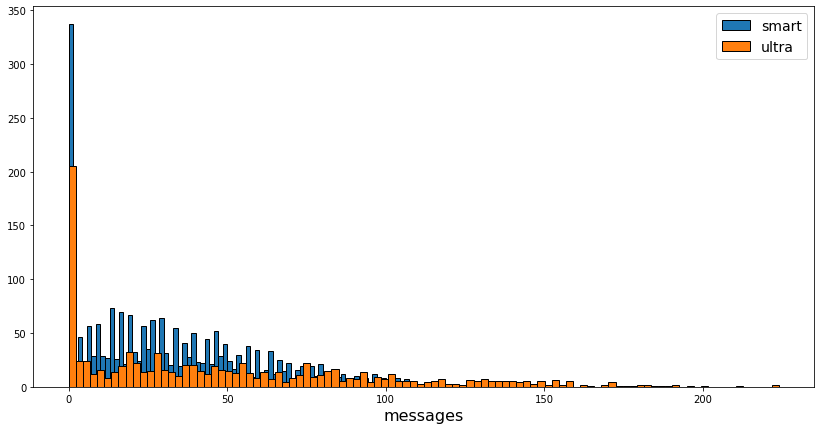

        Среднее  Дисперсия  Стандартное отклонение
tariff                                            
smart      33.4      796.8                    28.2

        Среднее  Дисперсия  Стандартное отклонение
tariff                                            
ultra      49.4     2285.3                    47.8


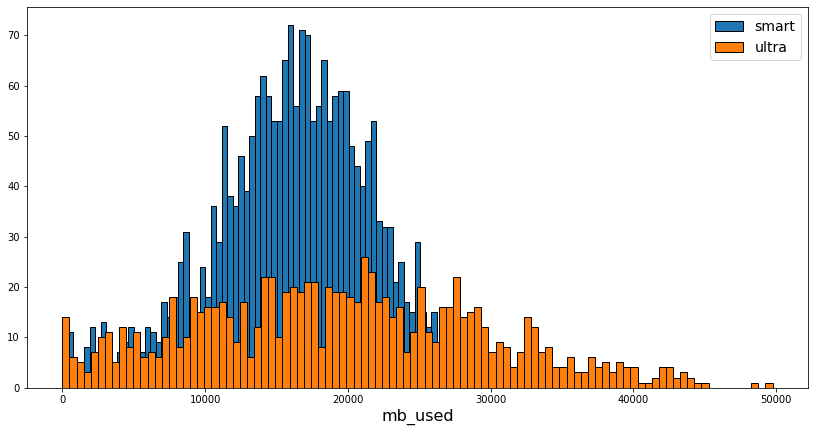

        Среднее   Дисперсия  Стандартное отклонение
tariff                                             
smart   16208.9  34462562.8                  5870.5

        Среднее    Дисперсия  Стандартное отклонение
tariff                                              
ultra   19469.3  101751558.0                 10087.2


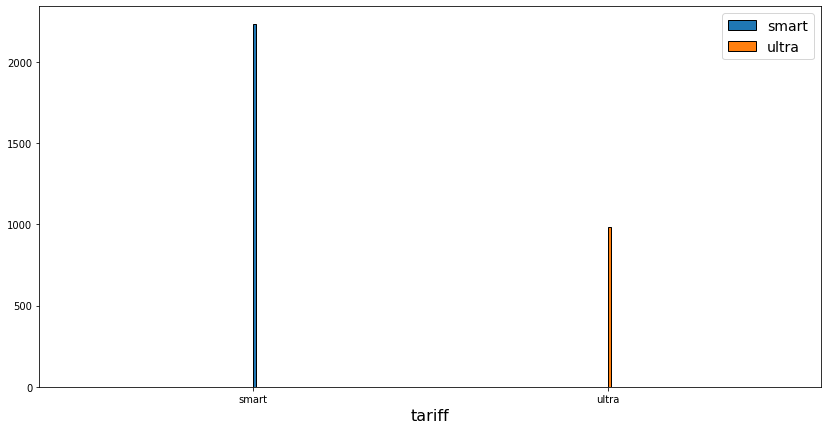

In [12]:
# фильтруем датафрейм по тарифу
data_grouped_smart = data_grouped[data_grouped['tariff'] == 'smart']
data_grouped_smart = data_grouped_smart[['duration','messages','mb_used', 'tariff']]
data_grouped_ultra = data_grouped[data_grouped['tariff'] == 'ultra']
data_grouped_ultra = data_grouped_ultra[['duration','messages','mb_used', 'tariff']]
# строим гистограмму для выбранных столбцов
for column in data_grouped_smart.columns.values.tolist() and data_grouped_ultra.columns.values.tolist():
    plt.figure(figsize=(14, 7))
    plt.hist(data_grouped_smart[column], bins=100, ec='black', label='smart')
    plt.hist(data_grouped_ultra[column], bins=100, ec='black', label='ultra')
    plt.legend(fontsize=14)
    plt.xlabel(column, fontsize=16)
    plt.show()
    try:
        tariff_smart = data_grouped_smart.pivot_table(index='tariff', values=column, aggfunc=['mean', 'var', np.std]).round(1)
        tariff_smart.columns = ['Среднее', 'Дисперсия', 'Стандартное отклонение']
        print(tariff_smart)
        print()
        tariff_ultra = data_grouped_ultra.pivot_table(index='tariff', values=column, aggfunc=['mean', 'var', np.std]).round(1)
        tariff_ultra.columns = ['Среднее', 'Дисперсия', 'Стандартное отклонение']
        print(tariff_ultra)
    except:
        print()

Пользователи тарифа «Смарт» в среднем тратят 418 минут разговора в месяц из 500 входящих в тариф, стандарное отклонение - 190 минут.

Пользователи в среднем отправляют 33 сообщения в месяц из 50 входящих в тариф, стандартное отклонение - 28 сообщений.

Пользователи потратили в среднем 16217 мб. трафика из 15000 мб. входящих в тариф, стандартное отклонение - 5873 мб.

Пользователи тарифа «Смарт» в среднем используют больше трафика и меньще минут, и смс, чем включено в тариф.

В среднем пользователи тарифа «Ультра» тратят 527 минут в месяц из 3000 входящих в тариф, стандарное отклонение - 318 минут.

Пользователи отправляют в среднем 49 сообщений в месяц из 1000 доступных, стандартное отклонение - 48 сообщений. 

Пользователи потратили в среднем 19471 мб. трафика из 30000 мб. доступных, стандарное отклонение - 10087 мб.

Пользователи тарифа «Ультра» почти не пользуются звонками и смс, и не тратят весь доступный лимит.

## Проверим гипотезы.

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

<i>H<sub>0</sub></i> — средняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

<i>H<sub>1</sub></i> — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [13]:
ultra = data_grouped[data_grouped['tariff'] == 'ultra']['revenue']
smart = data_grouped[data_grouped['tariff'] == 'smart']['revenue']

alpha = 0.05

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8160196659202846e-298
Отвергаем нулевую гипотезу


<AxesSubplot:>

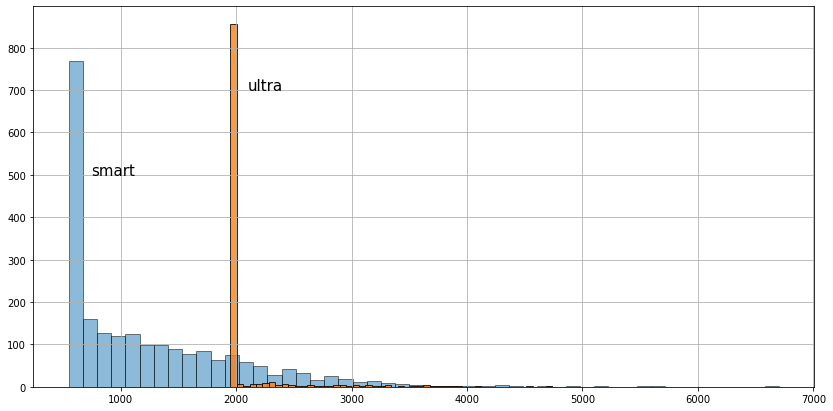

In [14]:
plt.text(750, 500, "smart", fontsize=15)
plt.text(2100, 700, "ultra", fontsize=15)
smart.hist(bins=50, alpha = 0.5, figsize=(14, 7), ec='black')
ultra.hist(bins=50, alpha = 0.8, figsize=(14, 7), ec='black')

In [15]:
data_grouped.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,958.0
ultra,1950.0


Гипотеза, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются верна. Более того, средние значения выручки по тарифам различаются почти в 2 раза.

<i>H<sub>0</sub></i> — средняя выручка пользователей из Москвы и из других регионов равна.

<i>H<sub>1</sub></i> — средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [16]:
for user in data_grouped.index:
    data_grouped.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = data_grouped.query('city == "Москва"')['revenue']
regions = data_grouped.query('city != "Москва"')['revenue']

alpha = 0.05

results = st.ttest_ind(moscow, regions, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.45044266676645206
Не получилось отвергнуть нулевую гипотезу


In [17]:
def det_region(city):
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Другие регионы'
    
data_grouped['region'] = data_grouped['city'].apply(det_region)
data_grouped.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другие регионы,1513.98
Москва,1699.36


Гипотеза, что выручка пользователей из Москвы и пользователей из других регионов различается не подтвердилась. Выручка в Москве почти не отличается от выручки в регионах.

Посчитаем, какой тариф, в среднем, приносит больше прибыли.

In [18]:
conclusion = data_grouped.pivot_table(index='tariff', values='revenue', aggfunc=['count', 'median'])
conclusion.columns = ['number of clients', 'revenue']
conclusion['total profit'] = conclusion['number of clients'] * conclusion['revenue']
display(conclusion)

,number of clients,revenue,total profit
tariff,,,
smart,2229,958.0,2135382.0
ultra,985,1950.0,1920750.0


## Общий вывод.

В среднем, пользователь тарифа «Ультра» приносит почти в двое больше денег, чем пользователь тарифа «Смарт». Cредняя выручка:
* «Ультра» - 1950
* «Смарт» - 958

Не смотря на это, лучшим тарифом для компании является «Смарт». В среднем на нем компания зарабатывает больше на 214 632, чем на тарифе «Ультра», из-за того, что пользователей трифа «Смарт» на 1 244 больше, чем пользователей тарифа «Ультра».

Регион никак не влияет на выручку, в Москве и регионах она почти не отличается.Cредняя выручка по регионам:
* Москва - 1701
* Другие регионы - 1515

Пользователи тарифа «Смарт» в среднем используют больше трафика и меньще минут, и смс, чем предусматривает их тариф. От сюда и средняя выручка в 958, при стоимости тарифа в 550.

Пользователи тарифа «Ультра» почти не пользуются звонками и смс, и не тратят весь доступный им лимит. Поэтому их средняя выручка равна ежемесячному платежу за тариф - 1950.